### Quantum Fourier Transform

In [1]:
# https://github.com/SRI-International/QC-App-Oriented-Benchmarks/tree/master/quantum-fourier-transform

In [2]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

from qiskit.visualization import plot_gate_map

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd ../..

from qml_transpiler import transpile_left

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


### Functions

In [3]:
def build_state_circuit(state):
    
    qubits_count = len(state)
    
    state_circuit = qiskit.QuantumCircuit(qubits_count)
    
    for index, bit in enumerate(state):
        
        if bit == "1":
            position = qubits_count - index - 1
            state_circuit.x(position)

    state_circuit.barrier(label="State")
    
    return state_circuit

In [4]:
def build_qft_circuit(qubits_count):
    
    qubits = list(range(qubits_count))
    
    circuit = qiskit.QuantumCircuit(qubits_count)
    
    for control_qubit in reversed(qubits):
        
        for target_qubit in reversed(range(control_qubit, qubits_count)):
            
            if control_qubit == target_qubit:
                
                circuit.h(control_qubit)
                
            else:
                
                theta = np.pi / 2 ** (target_qubit - control_qubit)
                
                circuit.crz(theta, control_qubit, target_qubit)
                
        circuit.barrier()
        
    return circuit

In [5]:
def build_fourrier_adder(qubits_count, number_to_add=1):
    
    circuit = qiskit.QuantumCircuit(qubits_count)
    
    for qubit in range(qubits_count):
        
        angle = number_to_add * (np.pi / 2 ** qubit)
        
        circuit.rz(angle, qubit)
        
    circuit.barrier(label="Adder")
    
    return circuit

### Backend

In [6]:
# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Parameters

In [7]:
QUBITS_COUNT = 5
NUMBER_TO_ADD = 2

EXPERIMENTS_COUNT = 10
SHOTS_COUNT = 1000

OPTIMIZATION_LEVEL = 3
SEED = 1234

### States

In [8]:
states_count = 2 ** QUBITS_COUNT

state_pattern = f">0{QUBITS_COUNT}b"

initial_states = [f"{state:{state_pattern}}" for state in range(EXPERIMENTS_COUNT)]

# initial_states

### Circuit

In [9]:
qft_circuit = build_qft_circuit(QUBITS_COUNT)

inverted_qft_circuit = qft_circuit.inverse()
    
fourrier_adder = build_fourrier_adder(QUBITS_COUNT, NUMBER_TO_ADD)

### Basic Transpilation - Slower one!

In [10]:
# Compose and Transpile

start_time = time()

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:
    
    state_circuit = build_state_circuit(initial_state)
    
    circuit = state_circuit.compose(qft_circuit)    
    circuit = circuit.compose(fourrier_adder)
    circuit = circuit.compose(inverted_qft_circuit)
    
    circuit.measure_all()
    
    # display(circuit.draw(fold=-1))
    
    transpiled_circuit = qiskit.transpile(
        circuit, 
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    transpiled_circuits.append(transpiled_circuit)
    
estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45 experiment/s]

estimated_time: 1.35


### Transpile Left - Much faster!

In [11]:
start_time = time()

# Transpile Central Part

central_circuit = qft_circuit.compose(fourrier_adder)    
central_circuit = central_circuit.compose(inverted_qft_circuit)

central_circuit.measure_all()

transpiled_central_circuit = qiskit.transpile(
    central_circuit, 
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)

# Transpile Left

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:
    
    state_circuit = build_state_circuit(initial_state)
    
    # display(circuit.draw(fold=-1))
    
    transpiled_circuit = transpile_left(
        transpiled_central_circuit, 
        left_circuit=state_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    transpiled_circuits.append(transpiled_circuit)
    
estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.13 experiment/s]

estimated_time: 0.26


### Run Circuits

In [12]:
counts_list = []

transpiled_circuit_tracker = tqdm(transpiled_circuits, unit=' circuit', ncols=110)

for transpiled_circuit in transpiled_circuit_tracker:

    job = backend.run(transpiled_circuit, shots=SHOTS_COUNT)

    counts = job.result().get_counts()

    counts_list.append(counts)

# counts_list

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66 circuit/s]


### Compare States

In [13]:
# Initial State Indices

initial_state_indices = [int(initial_state, 2) for initial_state in initial_states]

In [14]:
# Top State Indices

top_state_indices = []

for counts in counts_list:
    
    top_measured_state = max(counts, key=counts.get)
    
    top_state_index = int(top_measured_state, 2)
    
    top_state_indices.append(top_state_index)

In [15]:
# Check that Addition works

for initial_state_index, top_state_index in zip(initial_state_indices, 
                                                top_state_indices):
    
    assert top_state_index == (initial_state_index + NUMBER_TO_ADD) % states_count

In [16]:
# Global Counts

global_counts = np.zeros((EXPERIMENTS_COUNT, states_count), int)

for experiment, counts in enumerate(counts_list):
    
    for state, count in counts.items():
        
        state_index = int(state, 2)
        
        global_counts[experiment, state_index] = count

### Plots

In [17]:
def build_counts_figure(initial_states, measured_states, counts,
                        elevation=10, initial_azimuth=230):

    initial_states_grid, measured_states_grid = np.meshgrid(initial_states, measured_states)

    figure, ax = plt.subplots(figsize=(5, 5),
                              subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_states_grid,
                              measured_states_grid,
                              counts.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=True)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial State Index')
    ax.set_ylabel('Measured State Index')
    ax.set_zlabel('Count', rotation=90)
        
    ax.patch.set_alpha(0)
        
    figure.patch.set_alpha(0)
    
    # figure.patch.set_facecolor('black')
    
    plt.close()
    
    return figure    

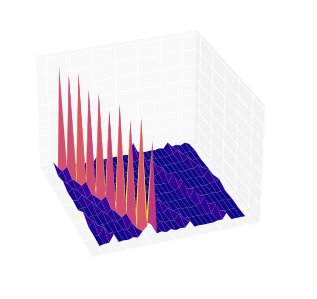

In [18]:
counts_figure = build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(states_count),
    counts=global_counts,
    elevation=30,
    initial_azimuth=160+180
)

counts_figure

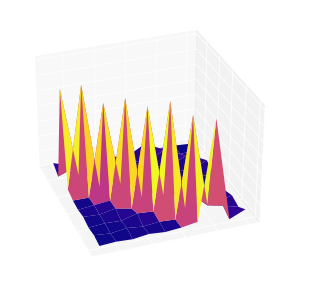

In [19]:
limited_counts_figure = build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(EXPERIMENTS_COUNT),
    counts=global_counts[:,:10],
    elevation=30,
    initial_azimuth=160
)

limited_counts_figure

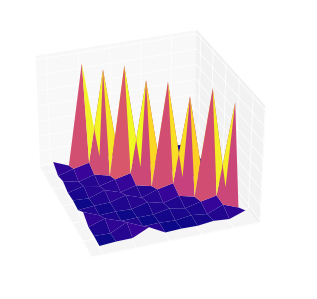

In [20]:
inverted_counts_figure = build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(EXPERIMENTS_COUNT),
    counts=global_counts[:,:10],
    elevation=30,
    initial_azimuth=160-180
)

inverted_counts_figure

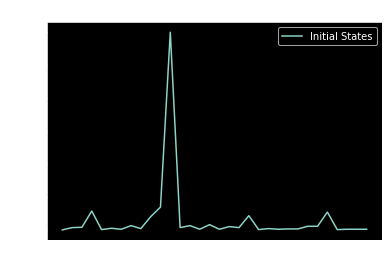

In [21]:
# Plot Counts

plt.title("Counts")
plt.xlabel("State Index")
plt.ylabel("Count")

plt.plot(global_counts[-1], label="Initial States")

plt.legend()

plt.show()

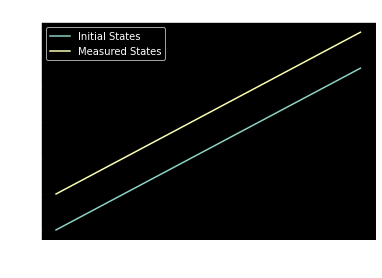

In [22]:
# Plot Transpilation times

plt.title("State Comparison")
plt.xlabel("State Index")
plt.ylabel("State Value")

plt.plot(initial_state_indices, label="Initial States")
plt.plot(top_state_indices, label="Measured States")

plt.legend()

plt.show()

### Plot Results

In [24]:
results = np.load("/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler/examples/qft/results.npy",
                  allow_pickle=True).item()

basic_times = [results[qubit_count]['basic_transpilation'] for qubit_count in results]

left_times = [results[qubit_count]['transpile_left'] for qubit_count in results]

results

{8: {'basic_transpilation': 389.1, 'transpile_left': 19.8},
 7: {'basic_transpilation': 231.29, 'transpile_left': 16.27},
 6: {'basic_transpilation': 169.55, 'transpile_left': 13.77},
 5: {'basic_transpilation': 123.55, 'transpile_left': 13.11},
 4: {'basic_transpilation': 88.25, 'transpile_left': 13.62},
 3: {'basic_transpilation': 55.11, 'transpile_left': 12.04},
 2: {'basic_transpilation': 25.7, 'transpile_left': 11.75}}

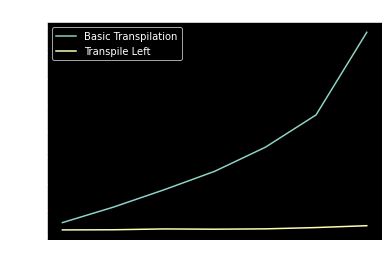

In [25]:
# Plot Transpilation times

qubit_counts = list(results.keys())

plt.title("Transpilation time comparison")
plt.xlabel("Qubits")
plt.ylabel("Transpilation time, seconds")

plt.plot(qubit_counts, basic_times, label="Basic Transpilation")
plt.plot(qubit_counts, left_times, label="Transpile Left")

plt.legend()

plt.show()